### License Plate Detection using YOLO11

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as xet
import cv2
import shutil

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.8/923.8 kB 15.8 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install -U ipywidgets -q

In [6]:
path = "/kaggle/input/car-plate-detection"

In [7]:
import re

def find_the_number(name_of_file):
    match = re.search(r'(\d+)',  name_of_file)
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

In [8]:
# Example usage
print(find_the_number("car5333.txt"))  # Output: 5333
print(find_the_number("no_numbers_here"))  # Output: 0

5333
0


In [9]:
# Initialize a dictionary to store labels and image information

labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

xml_files= glob(f"{path}/annotations/*.xml")
print(xml_files[:12])

['/kaggle/input/car-plate-detection/annotations/Cars339.xml', '/kaggle/input/car-plate-detection/annotations/Cars13.xml', '/kaggle/input/car-plate-detection/annotations/Cars74.xml', '/kaggle/input/car-plate-detection/annotations/Cars16.xml', '/kaggle/input/car-plate-detection/annotations/Cars291.xml', '/kaggle/input/car-plate-detection/annotations/Cars236.xml', '/kaggle/input/car-plate-detection/annotations/Cars429.xml', '/kaggle/input/car-plate-detection/annotations/Cars132.xml', '/kaggle/input/car-plate-detection/annotations/Cars251.xml', '/kaggle/input/car-plate-detection/annotations/Cars51.xml', '/kaggle/input/car-plate-detection/annotations/Cars165.xml', '/kaggle/input/car-plate-detection/annotations/Cars313.xml']


In [10]:
for file_name in sorted(xml_files, key=find_the_number):
    # Parse the XML file
    info = xet.parse(file_name)
    root = info.getroot()
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(path, 'images', img_name)
    
    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [12]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [13]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/kaggle/input/car-plate-detection/images/Cars1...,305,320,256,267,400,267
315,/kaggle/input/car-plate-detection/images/Cars3...,12,385,98,181,400,300
282,/kaggle/input/car-plate-detection/images/Cars2...,37,319,145,203,350,263
236,/kaggle/input/car-plate-detection/images/Cars2...,223,250,106,119,400,176
112,/kaggle/input/car-plate-detection/images/Cars1...,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/kaggle/input/car-plate-detection/images/Cars1...,286,328,133,159,400,267
255,/kaggle/input/car-plate-detection/images/Cars2...,116,273,156,188,400,267
292,/kaggle/input/car-plate-detection/images/Cars2...,91,137,187,208,400,267
54,/kaggle/input/car-plate-detection/images/Cars5...,148,257,61,118,400,300


In [15]:
def make_split_folter_in_yolo_formate(split_name, split_df):
    labels_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [16]:
# Create YOLO format folders for train, validation, and test splits
make_split_folter_in_yolo_formate("train", train)
make_split_folter_in_yolo_formate("val", val)
make_split_folter_in_yolo_formate("test", test)

Created 'datasets/car_license_plate_new/train/images' and 'datasets/car_license_plate_new/train/labels'
Created 'datasets/car_license_plate_new/val/images' and 'datasets/car_license_plate_new/val/labels'
Created 'datasets/car_license_plate_new/test/images' and 'datasets/car_license_plate_new/test/labels'


In [17]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: car_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [18]:
os.getcwd()

'/kaggle/working'

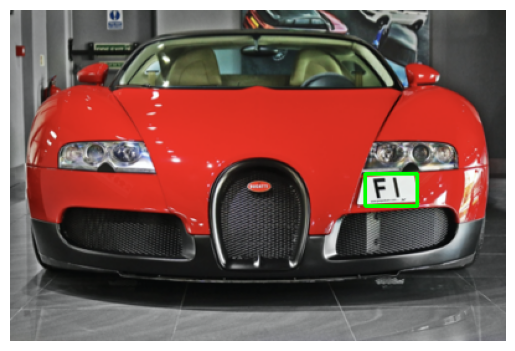

In [19]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = '/kaggle/working/datasets/car_license_plate_new/train/images'
label_dir = '/kaggle/working/datasets/car_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[10]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [20]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [21]:
model = YOLO('yolo11n.pt')

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.7MB/s]


In [ ]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics 8.3.87 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning /kaggle/working/datasets/car_license_plate_new/train/labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 206.33it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/car_license_plate_new/val/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 199.30it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.703G     0.8575     0.5345     0.9449         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

                   all         44         44      0.859      0.841      0.875      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.754G     0.8594     0.5169     0.9302         15        320: 100%|██████████| 22/22 [00:02<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]

                   all         44         44      0.861      0.844      0.876      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.754G     0.9165     0.5724      0.965         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         44         44      0.873      0.818      0.876      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.754G     0.9441     0.5795     0.9643         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.03it/s]

                   all         44         44      0.822      0.864      0.847      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.754G      1.025     0.6128     0.9788         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]

                   all         44         44      0.844      0.864       0.85      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.754G      1.019     0.6242      1.002         11        320: 100%|██████████| 22/22 [00:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]

                   all         44         44      0.842      0.845       0.87      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.754G      1.011     0.6313     0.9838         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         44         44      0.893      0.864      0.871      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.754G      1.077     0.6576      1.019         24        320: 100%|██████████| 22/22 [00:02<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.25it/s]

                   all         44         44      0.922      0.803       0.88      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.754G      1.027      0.644      1.018         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44        0.8      0.819       0.87      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.754G      1.024     0.6103      1.002         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.16it/s]

                   all         44         44      0.824      0.853      0.861      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.754G      1.028     0.6538      1.011         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]

                   all         44         44      0.874      0.788      0.849      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.754G      1.044     0.6465      0.999         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.23it/s]

                   all         44         44      0.874      0.841      0.883      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.754G      1.046     0.6483      1.011         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]

                   all         44         44      0.878      0.886      0.884      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.754G      1.014     0.6222     0.9856         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


                   all         44         44      0.891      0.841      0.896      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.754G      1.021      0.645      1.016         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all         44         44      0.855      0.909      0.913      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.754G      1.024     0.6212      1.002         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]

                   all         44         44      0.879      0.826      0.861      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.754G      1.002     0.6179      1.002         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all         44         44       0.86      0.841      0.866      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.754G      1.058     0.6211      1.012         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

                   all         44         44      0.839      0.886      0.865       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.754G     0.9954     0.6079     0.9848         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]

                   all         44         44      0.822      0.841      0.813      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.754G     0.9932     0.6207     0.9687         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]


                   all         44         44      0.856      0.864      0.856      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.754G     0.9686     0.5999       0.98         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.94it/s]

                   all         44         44      0.901      0.832       0.83      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.754G     0.9829     0.5938      0.978         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]

                   all         44         44      0.899      0.808      0.846      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.754G     0.9482     0.5941     0.9797         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.54it/s]

                   all         44         44      0.879      0.886      0.898      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.754G     0.9441     0.5992     0.9665         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]

                   all         44         44      0.817      0.812      0.821      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.754G     0.9916     0.5916     0.9758         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         44         44      0.802      0.864      0.847      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.754G     0.9327     0.5742     0.9674         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


                   all         44         44      0.812      0.909       0.88      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.754G     0.9516     0.5698     0.9839         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]

                   all         44         44      0.849      0.897      0.915      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.754G     0.9722      0.594     0.9758         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         44         44      0.905      0.863      0.927      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.754G     0.9723     0.5881     0.9698         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.05it/s]

                   all         44         44      0.912       0.75      0.869      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.754G     0.9706     0.5656     0.9622         31        320:  18%|█▊        | 4/22 [00:00<00:01, 10.34it/s]

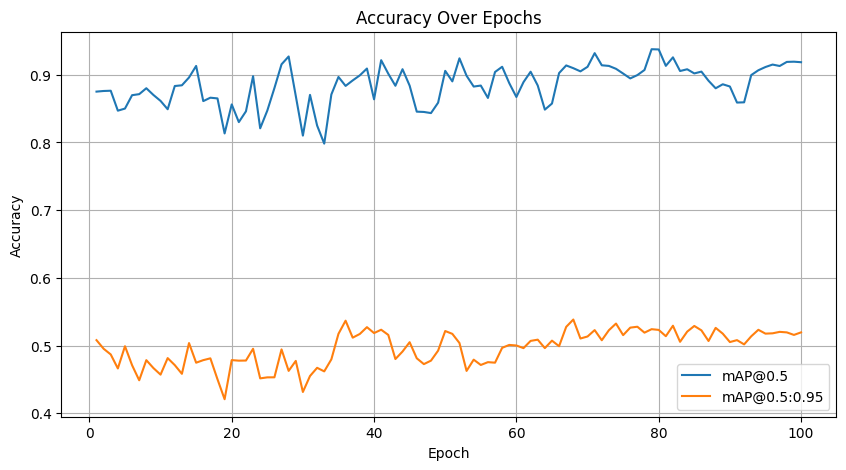

In [32]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=find_the_number)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [34]:
def predict_and_plot(path_test_car):
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 38.2ms
Speed: 2.2ms preprocess, 38.2ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)


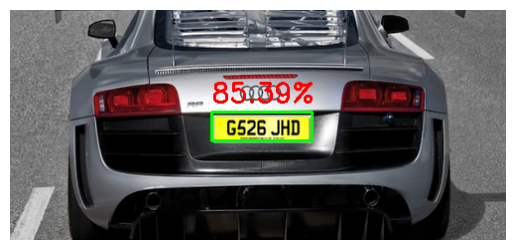

In [35]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 1 license_plate, 37.5ms
Speed: 0.9ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


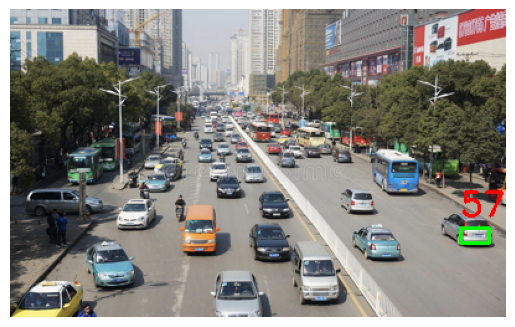

In [36]:
predict_and_plot(test.iloc[1].img_path)

## **Implementing Text Extraction**

In [37]:
!pip install pytesseract -q

In [38]:
import pytesseract
from pytesseract import Output

def predict_and_plot(path_test_car):
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 1 license_plate, 47.5ms
Speed: 1.3ms preprocess, 47.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
Detected text: > oF



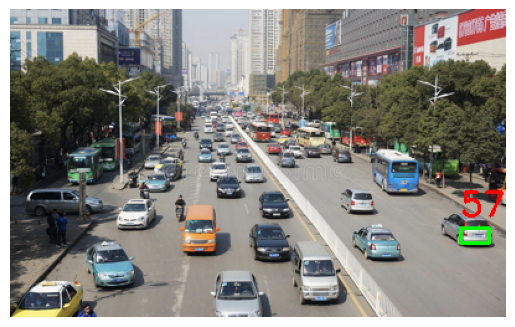

In [39]:
predict_and_plot(test.iloc[1].img_path)